# Model

In [ ]:
# | default_exp models.hospitalization

In [ ]:
# | export
from pyprojroot.here import here
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from isssm.typing import PGSSM
from tensorflow_probability.substrates.jax.distributions import Poisson
from jax import config

config.update("jax_enable_x64", True)

In [ ]:
# | export
from ssm4epi.models.util import from_consecutive_logits, to_consecutive_logits
import jax.scipy as jsp


def hospitalization_model(theta, aux) -> PGSSM:
    # log_s2_p, log_s2_q, *log_q = theta
    log_s2_p, log_s2_q, log_s2_W, log_s2_0, log_p0 = theta
    # log_q = jnp.array(log_q)
    s2_p = jnp.exp(log_s2_p)
    s2_q = jnp.exp(log_s2_q)
    s2_W = jnp.exp(log_s2_W)
    s2_0 = jnp.exp(log_s2_0)

    np1, n_delay, n_weekday, I = aux
    n = np1 - 1

    r = 1 + (n_delay - 1) + n_weekday
    m = (1 + 1) + (n_delay - 1) + 6 * n_weekday
    p = n_delay

    u0 = jnp.eye(m)[0] * log_p0
    # A_p = jnp.eye(1)
    A_p = jnp.array([[1.0, 1.0], [0.0, 1.0]])
    A_q = jnp.eye(n_delay - 1)
    A_W = jnp.array(
        [
            [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]
    )
    A = jsp.linalg.block_diag(A_p, A_q, *[A_W for i in range(n_weekday)])
    D = jnp.hstack(
        [
            jnp.eye(m)[:, 1 : n_delay + 1],
            jnp.eye(m)[:, n_delay + 1 : n_delay + 2],
            jnp.eye(m)[:, n_delay + 7 : n_delay + 8],
        ]
    )
    Sigma0 = s2_0 * jnp.eye(m)
    Sigma = jnp.diag(
        jnp.array([s2_p, *jnp.repeat(s2_q, n_delay - 1), *jnp.repeat(s2_W, n_weekday)])
    )

    # B = jnp.hstack((jnp.ones((p, 1)), jnp.eye(m - 1)))
    def B_W(i):
        return jnp.zeros((p, 6)).at[i + 1, 0].set(1.0)

    B_p = jnp.hstack((jnp.eye(p)[:, 0:1], jnp.zeros((p, 1))))
    B_logits = jnp.eye(p)[:, 1:]
    B_Ws = [B_W(i) for i in range(n_weekday)]
    B = jnp.hstack([B_p, B_logits, *B_Ws])

    u = jnp.zeros((np1, m)).at[0].set(u0)
    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, r))
    Sigma = jnp.broadcast_to(Sigma, (n, r, r))
    v = jnp.zeros((np1, p))
    B = jnp.broadcast_to(B, (np1, p, m))

    def hospitalization_dist(signal, xi):
        log_I7 = xi[..., :1, 0]

        log_p, logit_qs = jnp.split(signal, [1], axis=-1)
        log_delay_probs = jnp.log(from_consecutive_logits(logit_qs))
        log_lambda = log_I7 + log_p + log_delay_probs

        return Poisson(log_rate=log_lambda)

    dist = hospitalization_dist
    xi = jnp.broadcast_to(jnp.log(I)[:, None, None], (np1, p, 1))
    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

In [ ]:
# | export

import isssm.laplace_approximation
from jax.lax import cond


def _initial_guess(xi_t, y_t, dist, link=isssm.laplace_approximation.default_link):
    log_I7 = xi_t[0, 1]
    is_y_available = xi_t[:, 0] != 0
    log_p_est = jnp.log(y_t.sum()) - log_I7
    # slightly biased to avoid log(0)
    delay_probs_est = (y_t + 1.0) / (y_t + 1.0).sum()
    logit_delay_est = to_consecutive_logits(delay_probs_est)

    non_nan_guess = jnp.array([log_p_est, *logit_delay_est]) * jnp.concatenate(
        (jnp.array([1.0]), is_y_available[:-1])
    )
    # any_missing = jnp.any(xi_t[..., 0] == 0)
    # return cond(any_missing, lambda *_: nan_guess, lambda *_: non_nan_guess)
    return non_nan_guess


isssm.laplace_approximation._initial_guess = _initial_guess
from ssm4epi.patch import full_deps

In [ ]:
# | export

hospitalization_data = pd.read_csv(here() / "data/processed/seven_day_H_I_by_age.csv")

unique_a = hospitalization_data["a"].unique()
dates = hospitalization_data["s"].unique()
h_by_age = [
    jnp.asarray(
        hospitalization_data[hospitalization_data["a"] == a]
        .pivot(index="s", columns="k", values="h")
        .to_numpy()
    )
    for a in unique_a
]
I_by_age = [
    jnp.asarray(
        hospitalization_data[hospitalization_data["a"] == a]
        .pivot(index="s", columns="k", values="I")
        .to_numpy()
    )[:, 0]
    for a in unique_a
]

- NowcastHub period: Monday 22 November 2021 to Friday 29 April 2022
- date of final evaluation: 8 August 2022

In [ ]:
dates[0], dates[-1]

('2021-04-05', '2023-10-04')

In [ ]:
a_index = -1
h = h_by_age[a_index]
I = I_by_age[a_index]
unique_a[a_index]

'00+'

In [ ]:
[jnp.max(h_by_age[i].sum(axis=-1) / I_by_age[i]) for i in range(len(unique_a))]

[Array(0.88235294, dtype=float64),
 Array(0.42857143, dtype=float64),
 Array(0.20802005, dtype=float64),
 Array(0.31587057, dtype=float64),
 Array(0.74633431, dtype=float64),
 Array(1.09724473, dtype=float64),
 Array(0.63493344, dtype=float64)]

In [ ]:
np1 = 158
i_start = 260  # 231
i_end = i_start + np1

n_delay = 6
y = h[i_start : i_start + np1, :n_delay]

p0_hat = y[:7].sum() / I[i_start : i_start + 7].sum()
n_weekday = 2
aux = (np1, n_delay, n_weekday, I[i_start : i_start + np1])
theta_manual = jnp.log(
    jnp.array(
        [1**2, 1**2, 0.1**2, 0.1**2, p0_hat]  # s2_p  # s2_q  # s2_W  # p0  # s2_0
    )
)

model_manual = hospitalization_model(theta_manual, aux)

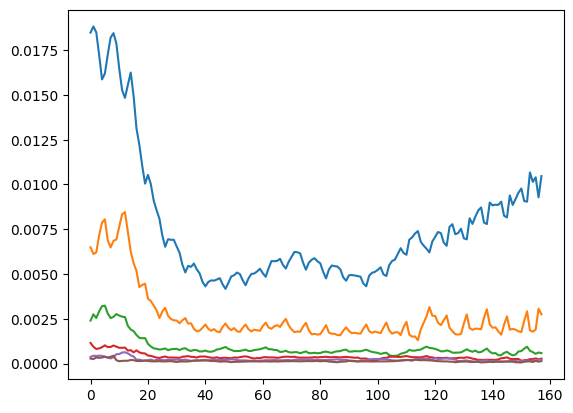

In [ ]:
plt.plot(y / I[i_start : i_start + np1][:, None])

In [ ]:
# | export
import pandas as pd

delays_per_age = pd.DataFrame(
    {"a_index": range(len(unique_a)), "n_delays": [5, 5, 7, 7, 8, 8, 8]}
)

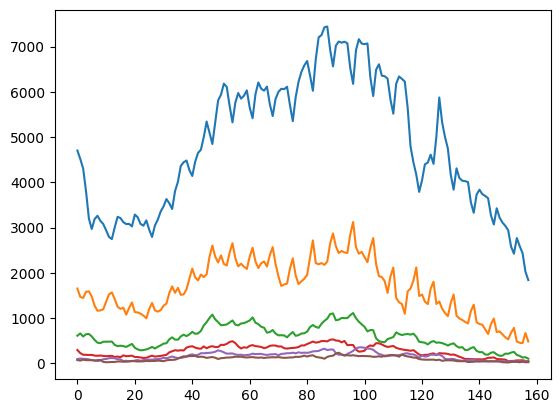

In [ ]:
plt.plot(y)
plt.show()

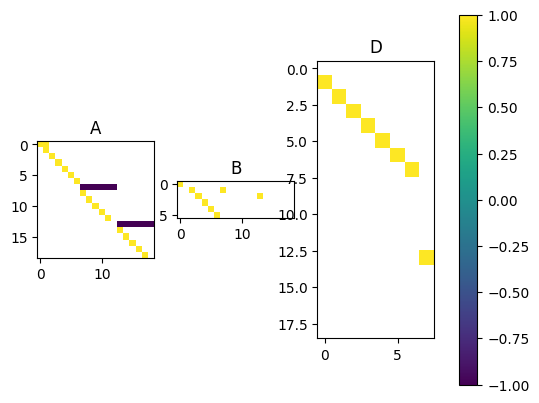

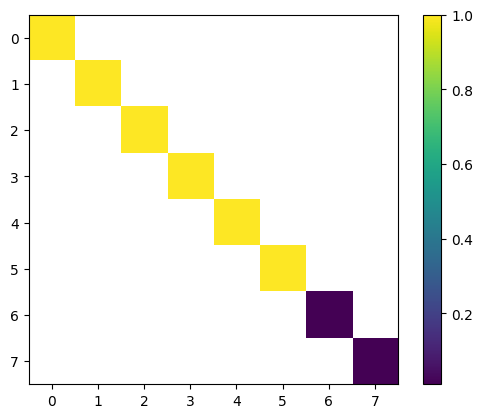

In [ ]:
from ssm4epi.models.util import visualize_pgssm

visualize_pgssm(model_manual)

In [ ]:
from isssm.estimation import initial_theta

theta0_result = initial_theta(y, hospitalization_model, theta_manual, aux, 100)
theta0 = theta0_result.x
theta0_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.256827861654503
        x: [-8.761e+00 -4.908e+00 -1.072e+01 -3.119e+00 -3.532e+00]
      nit: 36
      jac: [-1.549e-06  6.966e-07  4.007e-07  2.218e-06  5.756e-06]
 hess_inv: [[ 5.288e+01 -7.922e-03 ... -1.135e+00  2.247e+00]
            [-7.922e-03  5.991e+00 ...  2.864e-01 -1.159e-01]
            ...
            [-1.135e+00  2.864e-01 ...  1.022e+02 -5.347e+00]
            [ 2.247e+00 -1.159e-01 ... -5.347e+00  3.627e+01]]
     nfev: 440
     njev: 40

## Parameters

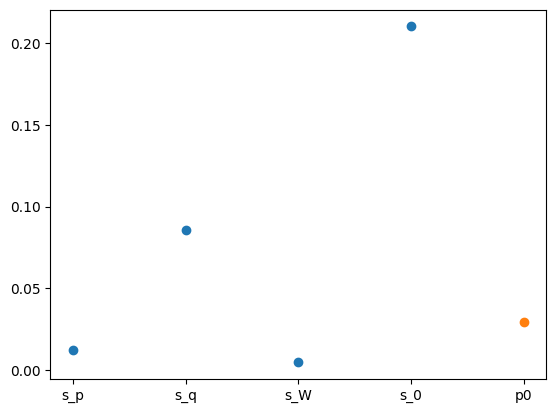

In [ ]:
model0 = hospitalization_model(theta0, aux)


def plot_parameters(theta0):
    sds = jnp.exp(theta0[:4] / 2)
    p0 = jnp.exp(theta0[4])
    plt.scatter(jnp.arange(4), sds)
    plt.scatter(4, p0)
    plt.xticks(jnp.arange(5), ["s_p", "s_q", "s_W", "s_0", "p0"])
    plt.show()


plot_parameters(theta0)

In [ ]:
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
import jax.random as jrn

proposal_la, info_la = LA(y, model0, 100)
key = jrn.PRNGKey(423423423)
key, subkey = jrn.split(key)
proposal_meis, info_meis = MEIS(
    y, model0, proposal_la.z, proposal_la.Omega, 100, 10000, subkey
)
key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y, model0, proposal_meis.z, proposal_meis.Omega, 1000, subkey
)
ess_pct(log_weights)

Array(85.38643487, dtype=float64)

In [ ]:
jnp.linalg.eigvalsh(proposal_la.Omega).min()

Array(8.53308697e-05, dtype=float64)

In [ ]:
# | export
from isssm.importance_sampling import mc_integration
from isssm.kalman import state_mode
from jax import vmap
from isssm.importance_sampling import ess_pct


def visualize_model_fit(samples, log_weights, model, i_start, np1, y, a_index):
    post = mc_integration(samples, log_weights)
    post_state = mc_integration(
        vmap(state_mode, (None, 0))(model, samples), log_weights
    )

    _, n_delay = y.shape

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle(f"Age group {unique_a[a_index]} - ESS {ess_pct(log_weights):.2f}%")
    fig.tight_layout()
    axs = axs.flatten()

    axs[0].plot(
        jnp.exp(post[:, 0]) * I_by_age[a_index][i_start : i_start + np1],
        label="predicted",
    )
    axs[0].plot(y.sum(axis=-1), label="truth")
    axs[0].legend()
    axs[0].set_title(f"Total hospitalizations after {n_delay} weeks")

    axs[1].plot(jnp.exp(post_state[:, 0]))
    axs[1].set_title("probability of hospitalization")

    axs[2].plot(from_consecutive_logits(post[:, 1:]), linestyle="--")
    axs[2].plot(from_consecutive_logits(post_state[:, 2 : (2 + n_delay - 1)]))
    axs[2].set_title("delay probabilities")

    axs[3].plot(post_state[:, 2 : (2 + n_delay - 1)])
    axs[3].set_title("delay logits")

    axs[4].plot(post_state[:, (2 + n_delay - 1)])
    axs[4].plot(post_state[:, (2 + n_delay - 1) + 6])
    axs[4].set_title("weekday effects")

    axs[5].plot(post_state[:, 1])
    axs[5].set_title("hosp. prob speed")

    plt.show()

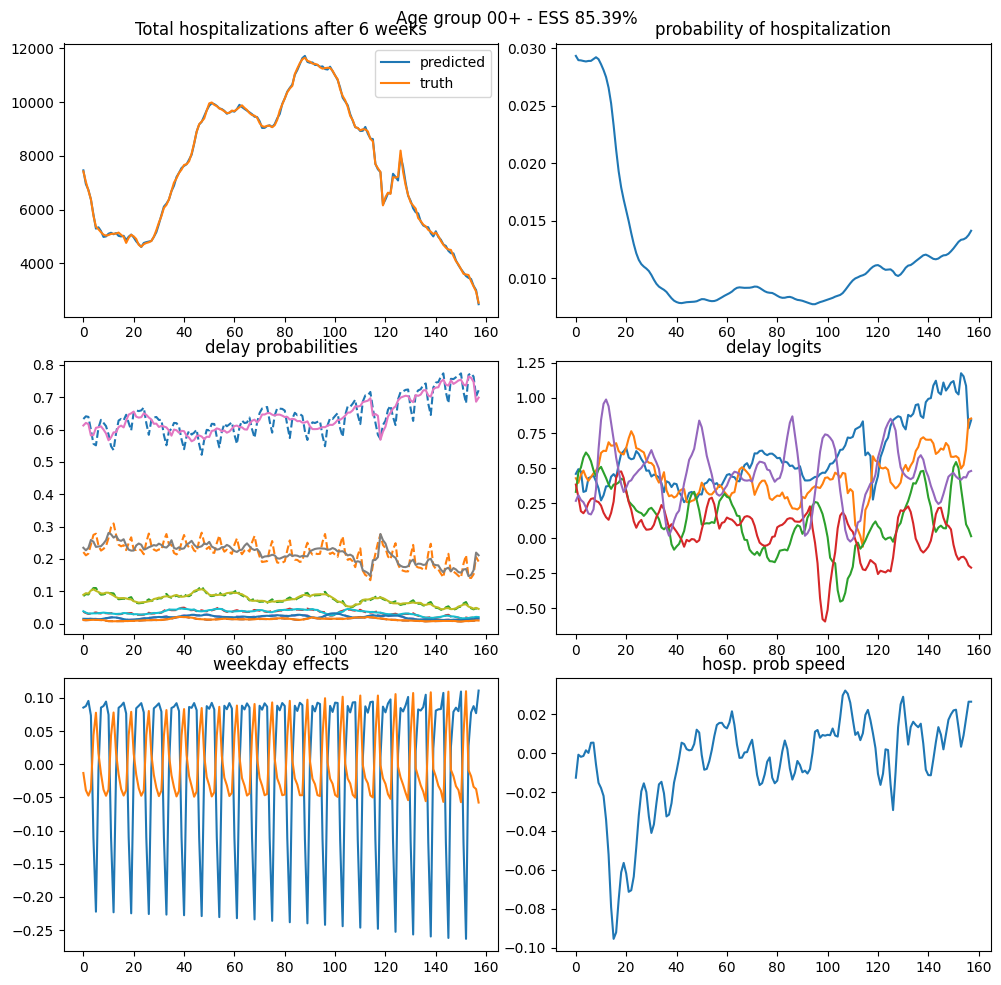

In [ ]:
visualize_model_fit(samples, log_weights, model0, i_start, np1, y, a_index)

# Missingness

Deviate from standard setup: now missing indices of $B$ differ from those of $Y$.

In [ ]:
# | export
from jaxtyping import Array, Float


def account_for_nans(
    model: PGSSM, y, missing_y_indices, missing_s_indices
) -> tuple[PGSSM, Float]:
    # only works for Poisson!
    # missing_indices = jnp.isnan(y)

    y_missing = jnp.nan_to_num(y, nan=0.0)

    v = model.v.at[missing_s_indices].set(0.0)
    B = model.B.at[missing_s_indices].set(0.0)

    xi_missing = jnp.ones_like(y).at[missing_y_indices].set(0.0)[..., None]
    xi = jnp.concatenate([xi_missing, model.xi], -1)

    def missing_dist(s, xi):
        xi_missing, old_xi = xi[..., 0], xi[..., 1:]
        old_dist = model.dist(s, old_xi)
        # if xi == 0. the log rate becomes -inf, so dist is dirac_0
        return Poisson(log_rate=old_dist.log_rate + jnp.log(xi_missing))

    model_missing = PGSSM(
        u=model.u,
        A=model.A,
        D=model.D,
        Sigma0=model.Sigma0,
        Sigma=model.Sigma,
        v=v,
        B=B,
        dist=missing_dist,
        xi=xi,
    )

    return model_missing, y_missing

test: make everything in the last week of observations missing, except initial observation

In [ ]:
# | export
from jax.lax import fori_loop


def make_y_nan(y: Float):
    _, n_delay = y.shape
    y_nan = y.astype(jnp.float64)
    for i in range(n_delay):
        y_nan = y_nan.at[(-7 * (i + 1) + 1) :, (i + 1) :].set(jnp.nan)
    return y_nan

In [ ]:
y_nan = make_y_nan(y)
# need fewer data for missingness
np1_miss = 100
y_nan = y_nan[-np1_miss:]
# y_nan = y_nan[:83]
np1_miss, _ = y_nan.shape
missing_y_indices = jnp.isnan(y_nan)
missing_s_indicies = jnp.concatenate(
    (jnp.full((np1_miss, 1), False, dtype=bool), missing_y_indices[:, :-1]), axis=-1
)
aux_miss = (np1_miss, n_delay, n_weekday, I[i_start + (np1 - np1_miss) : i_start + np1])

_, y_miss = account_for_nans(
    hospitalization_model(theta0, aux_miss),
    y_nan,
    missing_y_indices,
    missing_s_indicies,
)
_model_miss = lambda theta, aux: account_for_nans(
    hospitalization_model(theta, aux), y_nan, missing_y_indices, missing_s_indicies
)[0]

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 4.61938723602526
        x: [-8.761e+00 -4.613e+00 -1.072e+01 -3.055e+00 -3.662e+00]
      nit: 2
      jac: [ 3.004e-04 -7.560e-02 -7.003e-04 -1.635e-02  3.963e-02]
 hess_inv: [[ 1.000e+00 -1.310e-02 ... -2.867e-03  5.721e-03]
            [-1.310e-02  8.565e+00 ...  1.681e+00 -3.772e+00]
            ...
            [-2.867e-03  1.681e+00 ...  1.371e+00 -8.318e-01]
            [ 5.721e-03 -3.772e+00 ... -8.318e-01  2.853e+00]]
     nfev: 582
     njev: 52

## Parameter estimate

In [ ]:
# | export


def estimate_theta0_missing(y_nan, theta0, aux, i_start):

    np1 = aux[-1].shape[0]
    n_delay = aux[1]
    n_weekday = aux[2]

    # build model with full observations to determine theta
    # use only time points where all y values are available
    y_available = y_nan[~jnp.isnan(y_nan).any(axis=-1)]
    n_available, _ = y_available.shape
    aux_available = (
        n_available,
        n_delay,
        n_weekday,
        I[i_start + (np1 - n_available) : i_start + np1],
    )
    theta0_missing_result = initial_theta(
        y_available, hospitalization_model, theta0, aux_available, 100
    )
    return theta0_missing_result

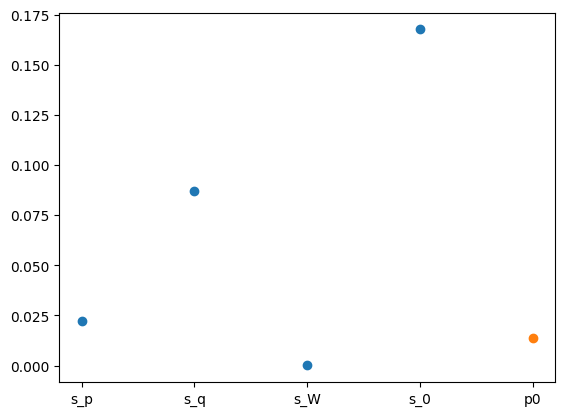

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.641690135301365
        x: [-7.624e+00 -4.882e+00 -2.155e+01 -3.572e+00 -4.286e+00]
      nit: 43
      jac: [ 1.113e-06 -7.624e-06  2.420e-08 -3.275e-06 -4.825e-06]
 hess_inv: [[ 4.046e+01  7.956e-01 ...  2.149e+00  1.062e+00]
            [ 7.956e-01  3.755e+00 ... -2.142e+00 -2.584e-01]
            ...
            [ 2.149e+00 -2.142e+00 ...  3.599e+01 -3.441e+00]
            [ 1.062e+00 -2.584e-01 ... -3.441e+00  8.980e+00]]
     nfev: 495
     njev: 45

In [ ]:
result = estimate_theta0_missing(y_nan, theta0, aux_miss, i_start)
theta0_missing = result.x
plot_parameters(theta0_missing)
result

In [ ]:
# | export
from ssm4epi.patch.full_deps import default_link
from isssm.typing import GLSSMProposal, ConvergenceInformation, GLSSM
from functools import partial
from jax import jit, jacfwd, jacrev, vmap
from jax.lax import while_loop
from isssm.util import converged
from isssm.kalman import kalman, smoothed_signals


def LA_missing(
    y: Float[Array, "n+1 p"],  # observation
    model: PGSSM,
    n_iter: int,  # number of iterations
    log_lik=None,  # log likelihood function
    d_log_lik=None,  # derivative of log likelihood function
    dd_log_lik=None,  # second derivative of log likelihood function
    eps: Float = 1e-5,  # precision of iterations
    link=default_link,  # default link to use in initial guess
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    np1, p, m = B.shape

    s_init = vmap(partial(_initial_guess, dist=dist, link=link))(xi, y)

    s_missing = (xi[..., 0] == 0.0).any(axis=-1)
    # if missing values, we want to have a larger initial guess
    # this is due to numerical issues with the Hessian:
    # it is ill-conditioned when $y \\approx \\lambda_1$
    s_init = s_init.at[s_missing, 0].set(s_init[s_missing, 0] + jnp.log(1.1))
    # s_init = jnp.zeros((np1, p))  # initial guess for the signal
    # missing values have zero obs. -> 0.
    # s_init = jnp.hstack(
    #    (jnp.log(y.sum(axis=1, keepdims=True) + 1.0), jnp.zeros((np1, 3)))
    # )

    def default_log_lik(
        s_t: Float[Array, "p"], xi_t: Float[Array, "p"], y_t: Float[Array, "p'"]
    ):
        return dist(s_t, xi_t).log_prob(y_t).sum()

    if log_lik is None:
        log_lik = default_log_lik

    if d_log_lik is None:
        d_log_lik = jacfwd(log_lik, argnums=0)
    if dd_log_lik is None:
        dd_log_lik = jacrev(d_log_lik, argnums=0)

    vd_log_lik = jit(vmap(d_log_lik))
    vdd_log_lik = jit(vmap(dd_log_lik))

    def _break(val):
        _, i, z, Omega, z_old, Omega_old = val

        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        all_converged = jnp.logical_and(z_converged, Omega_converged)

        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(all_converged, iteration_limit_reached)

    def _iteration(val):
        s, i, z_old, Omega_old, _, _ = val

        grad = vd_log_lik(s, xi, y)
        Gamma = -vdd_log_lik(s, xi, y)
        # pinv for missing values: if Gamma is 0, we want Omega to be 0 as well
        # requries exact derivatives, not numerical ones!
        Omega = jnp.linalg.pinv(Gamma, hermitian=True, rcond=1e-5)

        # z = s + jnp.linalg.solve(Gamma, grad[..., None])[..., 0]
        z = s + (Omega @ grad[..., None])[..., 0]
        approx_glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        filtered = kalman(z, approx_glssm)
        s_new = smoothed_signals(filtered, z, approx_glssm)

        return s_new, i + 1, z, Omega, z_old, Omega_old

    empty_z = jnp.empty_like(s_init)
    empty_Omega = jnp.empty((np1, p, p))
    init = (s_init, 0, empty_z, empty_Omega, empty_z, empty_Omega)

    _keep_going = lambda *args: jnp.logical_not(_break(*args))
    s, n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )

    final_proposal = GLSSMProposal(u, A, D, Sigma0, Sigma, v, B, Omega, z)

    return final_proposal, information

/var/folders/9y/xdxkkt710kx5tf1j0p68y46r0000gn/T/ipykernel_52604/869667675.py:70: DeprecationWarning: The rcond argument for linalg.pinv is deprecated. Please use rtol instead.
  Omega = jnp.linalg.pinv(Gamma, hermitian=True, rcond=1e-5)


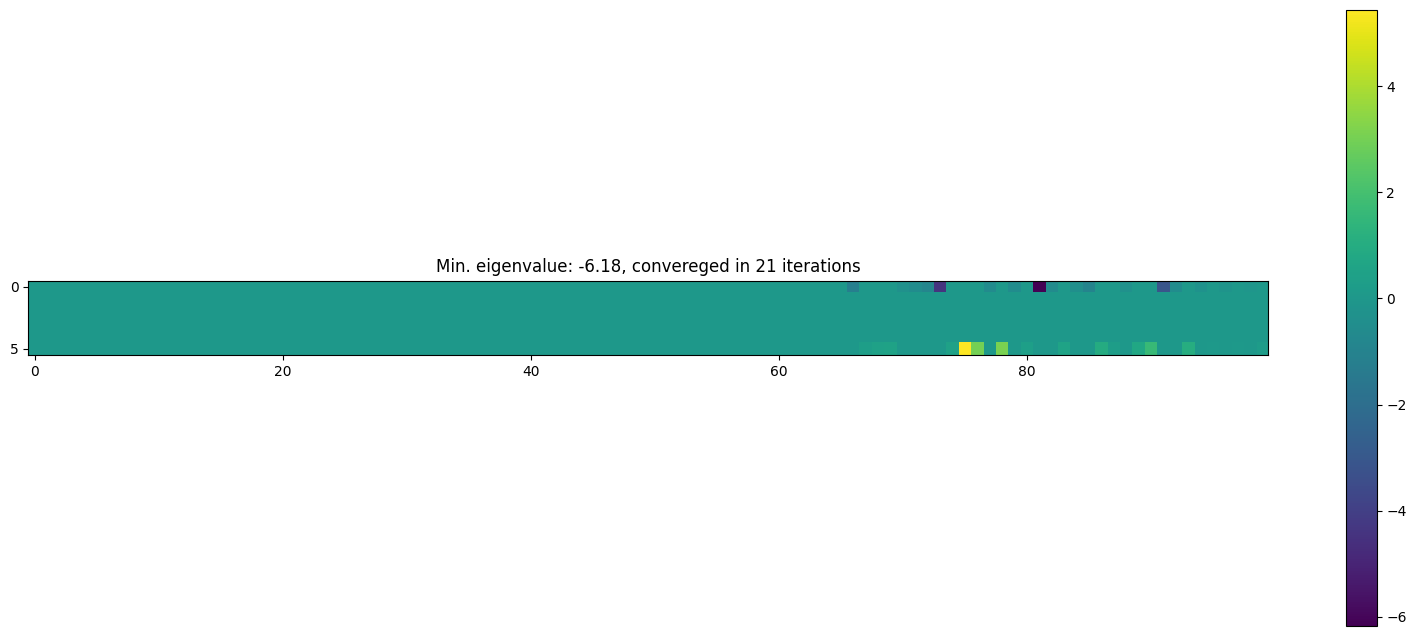

In [ ]:
model_miss0 = _model_miss(theta0_missing, aux_miss)
proposal_la, info_la = LA_missing(y_miss, model_miss0, 10000, eps=1e-10)
plt.figure(figsize=(20, 8))
plt.title(
    f"Min. eigenvalue: {jnp.linalg.eigvalsh(proposal_la.Omega).min():.2f}, convereged in {info_la.n_iter} iterations"
)
plt.imshow(jnp.linalg.eigvalsh(proposal_la.Omega).T)
plt.colorbar()

In [ ]:
jnp.linalg.eigvalsh(proposal_la.Omega).min()

Array(-6.17706532, dtype=float64)

[3325.93455402 1295.05228515  358.03265507    0.            0.
    0.        ]
[3326. 1295.  358.    0.    0.    0.]
-6.177065316487707


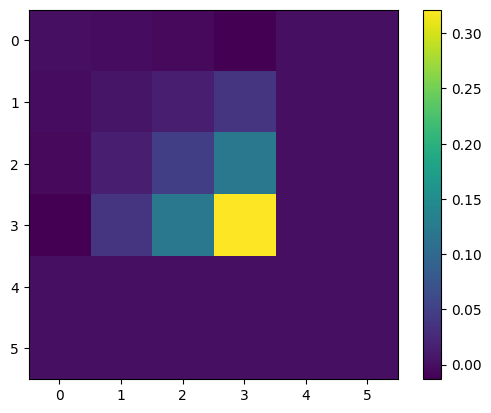

In [ ]:
# print(jnp.linalg.eigvalsh(proposal_la.Omega).min(axis=1)[80:])
# print(missing_y_indices[78:])
plt.imshow(proposal_la.Omega[80])
plt.colorbar()
print(jnp.exp(model_miss0.dist(proposal_la.z, model_miss0.xi).log_rate[80]))
print(y_miss[80])
print(jnp.linalg.eigvalsh(proposal_la.Omega).min())

In [ ]:
key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y_miss,
    model_miss0,
    proposal_la.z,
    proposal_la.Omega,
    1000,
    subkey,
)

ess_pct(log_weights)

Array(0.0823388, dtype=float64)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()

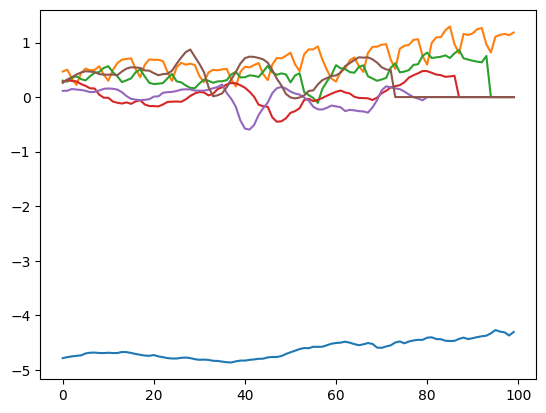

In [ ]:
from isssm.laplace_approximation import posterior_mode

plt.plot(posterior_mode(proposal_la))

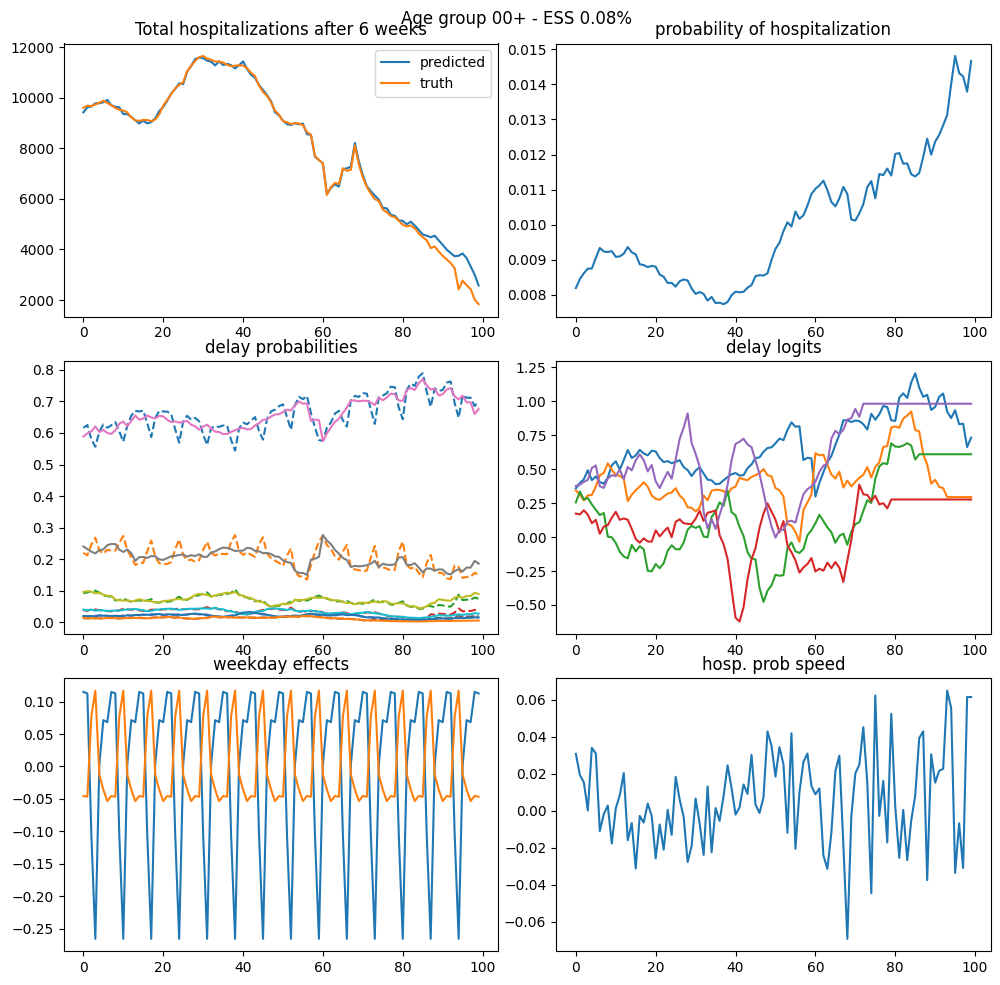

In [ ]:
visualize_model_fit(
    samples,
    log_weights,
    model_miss0,
    i_start + (np1 - np1_miss),
    np1_miss,
    y_miss,
    a_index,
)

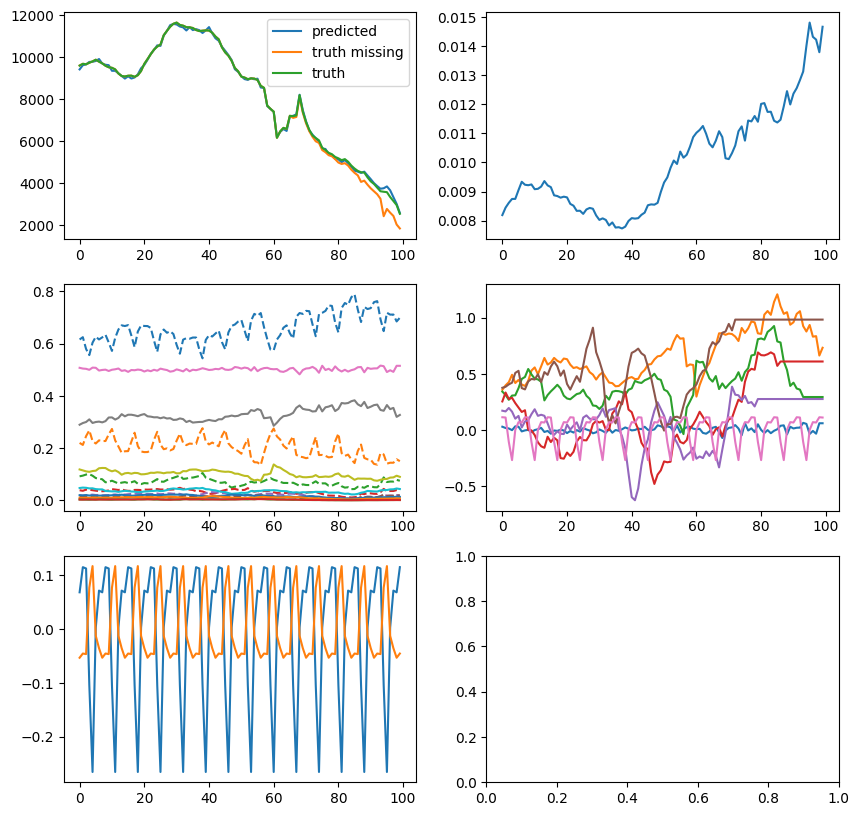

In [ ]:
post = mc_integration(samples, log_weights)
post_state = mc_integration(
    vmap(state_mode, (None, 0))(model_miss0, samples), log_weights
)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()
axs[0].plot(
    jnp.exp(post[:, 0]) * I[i_start + (np1 - np1_miss) : i_start + np1],
    label="predicted",
)
axs[0].plot(y_miss[-(np1_miss):].sum(axis=-1), label="truth missing")
axs[0].plot(y[-(np1_miss):].sum(axis=-1), label="truth")
axs[0].legend()

axs[1].plot(jnp.exp(post[:, 0]))

axs[2].plot(from_consecutive_logits(post[:, 1:]), linestyle="--")
axs[2].plot(from_consecutive_logits(post_state[:, 1:8]))
axs[3].plot(post_state[:, 1:8])
axs[4].plot(post_state[:, 8])
axs[4].plot(post_state[:, 8 + 6])

plt.show()

In [ ]:
from isssm.importance_sampling import prediction


def f_nowcast(x, s, y):
    return jnp.sum((missing_y_indices * y) + (1 - missing_y_indices) * y_miss, axis=-1)


key, subkey = jrn.split(key)
preds = prediction(
    f_nowcast,
    y_miss,
    proposal_la,
    _model_miss(theta0_missing, aux_miss),
    10000,
    subkey,
    jnp.array([0.025, 0.5, 0.975]),
    hospitalization_model(theta0_missing, aux_miss),
)

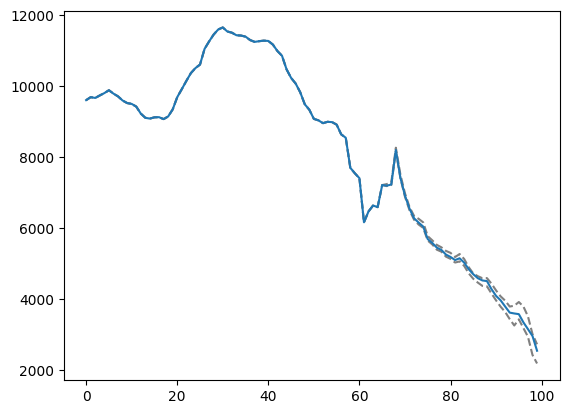

In [ ]:
# plt.plot(preds[0])
# plt.plot(preds[2][1])
plt.plot(jnp.clip(preds[2][0], 0.0), linestyle="--", color="grey")
plt.plot(preds[2][2], linestyle="--", color="grey")
plt.plot(y.sum(axis=-1)[-np1_miss:])
plt.show()

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()